# Biomass Proxy Workflows

The unique benefit of Biomass Proxy data is tied to the temporal dynamics of biomass processed to field scale. 
In this article, learn about the unique benefits of using the Subscriptions APIs to monitor and deliver 
Biomass Proxy data, walk through a typical workflow, and discover additional resources.



## Biomass Proxy in Subscriptions API

Biomass in agricultural fields is highly dynamic, changing throughout the growing season as plants grow, encounter stressors, and approach harvest. Timely and frequent access to biomass proxy data is essential for understanding these dynamics and making informed decisions regarding crop management, scouting, and intervention.

The Biomass Proxy Planetary Variable delivered through Planet's Subscriptions API provides the ability to track and respond to the highly dynamic nature of biomass in fields throughout the season. This enables better-informed decisions, input optimization, interventions, and harvest planning. Subscribing to Biomass Proxy data ensures consistent, up-to-date access to this valuable information, enabling users to track changes in biomass over time and respond accordingly.

Subscribe to the Biomass Proxy Planetary Variable to:

* Monitor crop growth and development: Users can track the growth and development of crops throughout the growing season, helping them to identify any issues early on and take appropriate action.

* Detect and respond to stressors: Frequent updates on biomass proxy data can help users detect stressors such as pests, diseases, or nutrient deficiencies. Timely access to this information allows users to respond more quickly and effectively, minimizing potential negative impacts on crop health and yield.

* Optimize inputs and interventions: By tracking biomass dynamics, users can make better-informed decisions about the timing and application of inputs such as fertilizers and pesticides, as well as plan targeted interventions to address issues in specific areas of the field.

* Improve harvest planning and efficiency: Access to up-to-date biomass proxy data can help users plan their harvest more effectively, by identifying areas of the field with higher biomass that may require adjusted harvest strategies or equipment settings.

## Workflow: monitor biomass proxy in soybean field during growing season

Accessing comprehensive and accurate environmental data is essential for optimizing agricultural practices and making informed decisions. The Biomass Proxy Planetary Variable offers information related to biomass dynamics, providing insights into vegetation growth and crop health. This example shows how to retrieve and analyze Biomass Proxy data using the Subscriptions API. Below, you can walk through the process of data retrieval, filtering, manipulation, and visualization. By harnessing the capabilities of the Subscriptions API, you can effectively leverage the Biomass Proxy Planetary Variables dataset to enhance your understanding of ecological dynamics within an agricultural context.

### Setting up your script and connecting with Planet services

To execute the code in this example, you need:

- Access to the BIOMASS-PROXY_V3.0_10 product for the provided field geometry.
- Configured credentials for storage of the results to cloud storage (Google Cloud, Amazon Web Services, Microsoft Azure or Oracle Cloud Suite)

### Subscription environment (required python packages)

The code examples in this workflow are written for Python 3.8 or greater (python>=3.8). In the next cell, you import the necessary libraries and external libraries. Aside from the built-in python libraries, the following packages are required additionally:

```
- requests
- pandas
- matplotlib
- rasterio
- keyring
```

To create a simple environment using `venv`, use the following commands. Review the [venv documentation](https://docs.python.org/3/library/venv.html#creating-virtual-environments) for creating environments on Windows/PowerShell.

```bash
# creation of virtual environment
python -m venv subscriptions
source subscriptions/bin/activate
python -m pip install -U pip

# installation of dependencies
pip install -U requests pandas matplotlib rasterio keyring
```

In [1]:
# Python builtins
import os
import datetime as dt
import json
import base64
import time
from getpass import getpass

# External requirements
import requests
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import keyring
from requests.auth import HTTPBasicAuth
from rasterio.plot import show

### Planet API Credentials

The [keyring](https://github.com/jaraco/keyring) package is used to store/retrieve the [Planet API key](https://developers.planet.com/quickstart/apis/#find-your-api-key). It should be entered once, and then it is stored on the system's keyring. Anyone with access to this system's user account can also access the keyring, so **only enter your Planet API key on a system's user account that only you can use**.


In [2]:
update = False  # Set to True if you want to update the credentials in the system's keyring

if keyring.get_password("planet", "PL_API_KEY") is None or update:
    keyring.set_password("planet", "PL_API_KEY", getpass("Planet API Key: "))
else: 
    print("Using stored API key")
PL_API_KEY = keyring.get_password("planet", "PL_API_KEY")

Using stored API key


Next, confirm your API key by making a call to Planet services and receive back `<Response [200]>`.


In [3]:
# Planet's Subscriptions API base URL for making restFUL requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

auth = HTTPBasicAuth(PL_API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
print(response)

<Response [200]>


### Google cloud credentials

In this example we'll be using Google Cloud for delivery of the results. One requires credentials for creating and accessing storage assets on an existingt cloud bucket.

See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key. When using AWS, Azure or OCS, use the appropriate credentials for those platforms.

In [4]:
BUCKET_NAME = "bp_test_api"  # the name of the bucket to deliver results to
GOOGLE_APPLICATION_CREDENTIALS = "key.json"   # path to the google application credentials key

if not os.path.exists(GOOGLE_APPLICATION_CREDENTIALS):
    credentials_path = os.path.abspath(GOOGLE_APPLICATION_CREDENTIALS)
    print(f"No google application credentials found at: {credentials_path}")


## Creating a Planetary Variables Subscription with the Subscriptions API

To create a subscription, provide a JSON request object that includes required information, such as source type, your GeoJSON, and others. For details on required parameters, see [Create a Planetary Variables Subscription](https://developers.planet.com/docs/subscriptions/pvs-subs/#create-a-planetary-variables-subscription) in [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/).




### Create your JSON subscription body object

To create a subscription, specify the date range, geometry and the delivery options for which to submit the subscription request.

#### Date range

Define start and end times for the request. These dates are equivalent to the acquisition dates of the input satellite sources to the biomass proxy. The biomass proxy is delivered daily with the data time set to 'T00:00:00.00Z', so only the date part of the datetime is relevant. 

In [5]:
start_time = dt.datetime(2020, 1, 15)
end_time = dt.datetime(2023, 4, 24)

#### Geometry

Biomass proxy is processed and delivered by field. The geometry to include in the request should be of type Polygon and should only cover a single field.

Use the geojson geometry representation for the field for which to create your subscription. If your file is in a different format, consider using [fiona](https://fiona.readthedocs.io/en/stable/README.html) for the conversion to geojson.

The current vertex limit (i.e. the maximum amount of coordinates in a geometry) is currently set to 500.

#### Gemetry permissions

In case one wants to check if the provided geometry fits into the area of access (AOA) see the following [code example](https://developers.planet.com/docs/subscriptions/api-mechanics/#permissions).

In [6]:
# field geometry polygon - Field in Ohio
field_geometry = {
    "type": "Polygon",
    "coordinates": [[[ -83.459351687641913, 40.187200874209744 ],
                     [ -83.452336405535007, 40.183794610065355 ],
                     [ -83.453350174625598, 40.18351075471999 ],
                     [ -83.454526146770689, 40.183835160828977 ],
                     [ -83.456796989533615, 40.182213130284033 ],
                     [ -83.459878847569016, 40.181888724175046 ],
                     [ -83.465069345312841, 40.176698226431213 ],
                     [ -83.493292676794908, 40.174751789777275 ],
                     [ -83.489602557305162, 40.176698226431213 ],
                     [ -83.483317188943488, 40.176698226431213 ],
                     [ -83.474963731637018, 40.180631650502711 ],
                     [ -83.470138190765795, 40.181564318066052 ],
                     [ -83.459351687641913, 40.187200874209744 ]
                  ]]
      }

#### Delivery (optional)

The delivery settings need to be specified so that results can be transferred to this location. At the moment one of the following options needs to be chosen:

1. `google_cloud_storage`
2. `amazon_s3`
3. `azure_blob_storage`
4. `oracle_cloud_storage`

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [api reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) and open the delivery options to review the options for each delivery type. In this example we will use Google cloud storage.

*Note: 
    Delivery settings are not required for Planetary Variables if only time-series results are desired.*

In [7]:
# Credentials are expected in base64 format, 
# the following reads the json key as bytes, applies the base64 encoding 
# and decodes back to a python str

with open(GOOGLE_APPLICATION_CREDENTIALS, 'rb') as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

delivery_settings = {
    "type": "google_cloud_storage", 
    "parameters": {
        "bucket": BUCKET_NAME,  # bucket name where the service account has write access
        "credentials": gcs_credentials_base64
    }
}

#### Headers

Set the headers for the request.

In [8]:
headers = {
    'content-type': 'application/json'  # set content type of the response to json
}

To create the full body for the request, use the following structure.

In [9]:
# Create a new subscription JSON object
subscription_payload = {
   "name": "Soybean Ohio Field 3 yrs BIOMASS-PROXY_V3.0_10 example",
   "source": {
       "type": "biomass_proxy",
       "parameters": {
           "id": "BIOMASS-PROXY_V3.0_10",
           "start_time": start_time.strftime("%Y-%m-%dT%H:%M:%SZ"),  # 'YYYY-MM-DDTHH:MM:SSZ'
           "end_time": end_time.strftime("%Y-%m-%dT%H:%M:%SZ"),  # 'YYYY-MM-DDTHH:MM:SSZ'
           "geometry": field_geometry
       }
   },
   "delivery": delivery_settings
}

### Submit the subscription

This is where you make the request to Planet and receive your subscription ID. The subscription ID is stored for later retrieval of data when the delivery has finished.

In the following example, the subsription is submitted for processing (in the try block). The result is either a succesful request with a subscription id returned by the api (in the else block), or a description on why the subscription request failed (except block).

In [10]:
try:
    response = requests.post(BASE_URL, json=subscription_payload, auth=auth, headers=headers)
    response.raise_for_status()  # raises an error if the request was malformed
except requests.exceptions.HTTPError:
    print(f"request failed with {response.text}")  # show the reason why the request failed
else:
    response_json = response.json()
    subscription_id = response_json["id"]
    print(f"Successful request with {subscription_id=}")

Successful request with subscription_id='94c7ed2d-17ea-46d6-819b-054ead1cd463'


To retrieve the status of the subscription, request the subscription endpoint with a GET request. Once it is in `running` or `completed` state, the delivery is either in progress or completed, respectively. A subscription with an end date in the future remains in `running` state until the `end_date` is in the past. See [status descriptions](https://developers.planet.com/docs/subscriptions/#subscription-status) for the complete overview of possible status descriptions.

In [11]:
subscription_uri = f"{BASE_URL}/{subscription_id}"
subscription_response = requests.get(subscription_uri, auth=auth)
subscription_response.json()

{'name': 'Soybean Ohio Field 3 yrs BIOMASS-PROXY_V3.0_10 example',
 'source': {'type': 'biomass_proxy',
  'parameters': {'end_time': '2023-04-24T00:00:00Z',
   'geometry': {'coordinates': [[[-83.45935168764191, 40.18720087420974],
      [-83.45233640553501, 40.183794610065355],
      [-83.4533501746256, 40.18351075471999],
      [-83.45452614677069, 40.18383516082898],
      [-83.45679698953361, 40.18221313028403],
      [-83.45987884756902, 40.181888724175046],
      [-83.46506934531284, 40.17669822643121],
      [-83.49329267679491, 40.174751789777275],
      [-83.48960255730516, 40.17669822643121],
      [-83.48331718894349, 40.17669822643121],
      [-83.47496373163702, 40.18063165050271],
      [-83.4701381907658, 40.18156431806605],
      [-83.45935168764191, 40.18720087420974]]],
    'type': 'Polygon'},
   'id': 'BIOMASS-PROXY_V3.0_10',
   'start_time': '2020-01-15T00:00:00Z'}},
 'delivery': {'type': 'google_cloud_storage',
  'parameters': {'bucket': 'bp_test_api', 'credentials'

## Inspect results

Once the results have been delivered to the bucket, they can be requested using the results endpoint. The results for this endpoint are paginated, meaning multiple requests need to be made to retrieve all available results. See more on [pagination](https://developers.planet.com/docs/subscriptions/api-mechanics/#pagination).

The following code block shows the first page of the results. In the `'_links'` section, there is a reference to the next page under `'next'`.

*Note:
    It may take 30 minutes up until several hours before the subscription results will have been delivered. After the initial update, it will then update daily. It is possible to [configure notifications to a webhook](https://developers.planet.com/docs/subscriptions/notifications/) to capture events like a subscription status change, or a delivery match.*


In [12]:
subscription_results_uri = f"{BASE_URL}/{subscription_id}/results"
subscription_results_response = requests.get(subscription_results_uri, auth=auth)
results_page_response = subscription_results_response.json()
results_page_response["results"][1:-1] = ['...truncated...']  # truncate results for readability
results_page_response

{'_links': {'_self': 'https://api.planet.com/subscriptions/v1/94c7ed2d-17ea-46d6-819b-054ead1cd463/results',
  'next': 'https://api.planet.com/subscriptions/v1/94c7ed2d-17ea-46d6-819b-054ead1cd463/results?page_marker=2023-07-04T13%3A49%3A05.193177Z'},
 'results': [{'id': '3b8e3ac7-c465-4102-b261-4362a5fdbcc9',
   'status': 'success',
   'properties': {'item_id': 'BIOMASS-PROXY_V3.0_10_2022-09-14T0000',
    'local_solar_time': '2022-09-14T00:00',
    'source_id': 'BIOMASS-PROXY_V3.0_10',
    'statistics': [{'asset': 'bp',
      'band': 'band-1',
      'name': 'mean',
      'type': 'number',
      'value': 0.64},
     {'asset': 'bp',
      'band': 'band-1',
      'name': 'valid_percent',
      'type': 'number',
      'value': 100}]},
   'created': '2023-07-04T13:49:06.071727Z',
   'updated': '2023-07-04T13:49:39.35732Z',
   'completed': '2023-07-04T13:49:39.35732Z',
   'errors': {},
   'outputs': ['94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/09/14/BIOMASS-PROXY_V3.0_10-20220914T0000_bp.tif

To retrieve all pages from the results endpoint for a single subscription, use the following function. It iterates over the result pages with several filter options. It also has a rate limit of 5 requests per second to avoid too many request errors. 

This function serves merely as an example, as it does not include all available API filters nor does it handle errors and automatic retries. For more available filters on the API, consult the [results API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/results)

In [13]:
def retrieve_results(subscription_id, status=None, item_start_time=None, item_end_time=None, page_size=200):
    """Retrieve results from all pages
    
    Parameters
    ----------
    subscription_id
        subscription id for which to request the results
    status
        status to filter on
    item_start_time
        filter item start time after this datetime (inclusive)
    item_end_time
        filter item end time before this datetime (exclusive)
    page_size
        amount of results per page [0 .. 10000]
    
    """
    params = {"page_size": page_size}
    if status is not None:
        params["status"] = status
    if item_start_time is not None or item_end_time is not None:
        item_start_time = '..' if item_start_time is None else item_start_time.strftime("%Y-%m-%dT%H:%M:%S.00Z")
        item_end_time = '..' if item_end_time is None else item_end_time.strftime("%Y-%m-%dT%H:%M:%S.00Z")
        params["item_datetime"] = f"{item_start_time}/{item_end_time}" 
    
    results = []
    subscription_results_uri = f"{BASE_URL}/{subscription_id}/results"
    subscription_results_response = requests.get(
        subscription_results_uri, 
        params=params, 
        auth=auth,
        headers=headers,
    )
    subscription_results_response.raise_for_status()
    subscription_results_response_json = subscription_results_response.json()
    
    # Keep requesting new pages until the end is reached
    while next_page := subscription_results_response_json["_links"].get("next"):
        time.sleep(0.2)  # avoid exceeding the rate limit
        results.extend(subscription_results_response_json["results"])
        subscription_results_response = requests.get(
            next_page, 
            auth=auth,
            headers=headers,
        )
        subscription_results_response.raise_for_status()
        subscription_results_response_json = subscription_results_response.json()
    
    # store the results of the last page
    results.extend(subscription_results_response_json["results"])
    return results


### Result objects

The result objects file locations can be found by filtering all results on 'success' state and extracting the 'outputs' from the result items. For the biomass proxy the result outputs contain a single asset `bp`. 

In the following block, the succeeded first three months of 2022 results are obtained. An example of a single result item is shown in the console output.

In [14]:
results = retrieve_results(
    subscription_id, 
    status="success", 
    item_start_time=dt.datetime(2022, 1, 1),
    item_end_time=dt.datetime(2022, 4, 1, 7),  # the item_datetime for bp is set to T06:00:00.00Z
    page_size=100,
)
if len(results) == 0:
    print("No results are available yet, please wait before retrying")

print("Example result:")
results[0]

Example result:


{'id': 'e6197c18-f952-48aa-9901-0e9d0d05f050',
 'status': 'success',
 'properties': {'item_id': 'BIOMASS-PROXY_V3.0_10_2022-02-08T0000',
  'local_solar_time': '2022-02-08T00:00',
  'source_id': 'BIOMASS-PROXY_V3.0_10',
  'statistics': [{'asset': 'bp',
    'band': 'band-1',
    'name': 'mean',
    'type': 'number',
    'value': 0.26},
   {'asset': 'bp',
    'band': 'band-1',
    'name': 'valid_percent',
    'type': 'number',
    'value': 100}]},
 'created': '2023-07-04T13:49:02.629815Z',
 'updated': '2023-07-04T13:49:38.056787Z',
 'completed': '2023-07-04T13:49:38.056787Z',
 'errors': {},
 'outputs': ['94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/02/08/BIOMASS-PROXY_V3.0_10-20220208T0000_bp.tiff'],
 'item_datetime': '2022-02-08T06:00:00Z'}

The outputs refer to the bucket location on the bucket that was provided under the delivery options during the subscription request creation.

Composing the full object paths can be done using the following snippet. It assumes that the first asset is `bp`, which it always is because only a single asset is delivered for biomass proxy v3.

In [15]:
output_blobs = [f"gs://{BUCKET_NAME}/{result['outputs'][0]}" for result in results[::30]]
output_blobs

['gs://bp_test_api/94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/02/08/BIOMASS-PROXY_V3.0_10-20220208T0000_bp.tiff',
 'gs://bp_test_api/94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/01/09/BIOMASS-PROXY_V3.0_10-20220109T0000_bp.tiff',
 'gs://bp_test_api/94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/03/23/BIOMASS-PROXY_V3.0_10-20220323T0000_bp.tiff',
 'gs://bp_test_api/94c7ed2d-17ea-46d6-819b-054ead1cd463/2022/02/19/BIOMASS-PROXY_V3.0_10-20220219T0000_bp.tiff']

### Plot example with Rasterio

To access the cloud objects, we can use [Rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) to read and visualize data directly from the bucket.

The credentials needed to access data from the cloud need to be set using the [rasterio.env.Env](https://rasterio.readthedocs.io/en/latest/api/rasterio.env.html#module-rasterio.env) context manager as shown in the example.

There are many options for configuring access through the different cloud storage services. Rasterio uses GDAL under the hood, and the configuration options for [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) notably:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from a Google Cloud address using the service account access credentials by Google. It shows all rasters from `output_blobs` composed in the previous cell and plots them into a single Matplotlib figure.

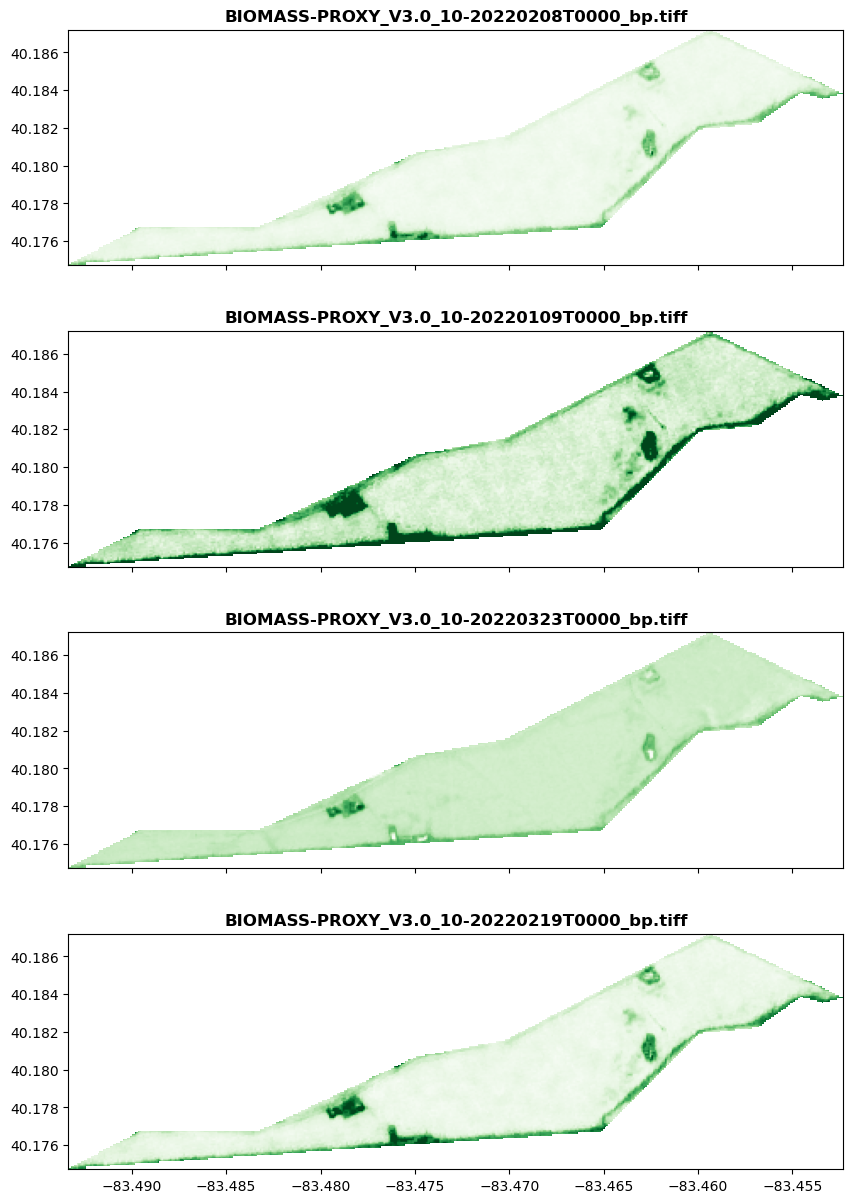

In [16]:
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
    f, axs = plt.subplots(len(output_blobs), 1, figsize=(10, 15), sharex=True)
    for blob_name, ax in zip(output_blobs, axs):
        with rasterio.open(blob_name) as src:
            show(src, ax=ax, transform=src.transform, cmap="Greens", title=os.path.basename(blob_name))

### Result time series
Aside from output files, there is already the pre-generated statistic 'mean' included in the results. In the following example, the mean values are directly extracted from the results and stored into a pandas dataframe, without having to interact with the files stored in the delivery bucket.

In [17]:
results = retrieve_results(
    subscription_id, 
    status="success",
    page_size=300,
)

The following function can be used to retrieve the local solar time and the statistics from the results obtained from the results endpoint. It places all available statistics from the results under the keys composed by: `{asset-name}-{band-id}-{statistics-name}`.

In [18]:
def extract_result_statistics(result_list):
    local_solar_time = []
    statistics = []
    
    for result in results:
        
        local_solar_time.append(dt.datetime.strptime(result["properties"]["local_solar_time"][:10], "%Y-%m-%d"))
        item_statistics = {}
        
        for statistic in result["properties"]["statistics"]:
            if statistic['type'] != "number":
                continue
            item_statistics[f"{statistic['asset']}-{statistic['band']}-{statistic['name']}"] = statistic["value"]
        statistics.append(item_statistics)
    
    return local_solar_time, statistics

Using the function defined above this cell, one can extract statistics from result items, and create a dataframe with the local solar time as datetime index as follows. The columns are renamed to `'bp-mean'` and `'bp-valid'` as there are only two statistics for Biomass Proxy.

In [19]:
local_solar_time, statistics = extract_result_statistics(results)
df = pd.DataFrame(statistics, index=pd.DatetimeIndex(local_solar_time))
df.sort_index(inplace=True)
df.rename(columns={"bp-band-1-mean": "bp-mean", "bp-band-1-valid_percent": "bp-valid"}, inplace=True)

To show the data from this dataframe, the following plot shows the dataframe values over time with the valid percentage on the right axis.

(0.0, 105.0)

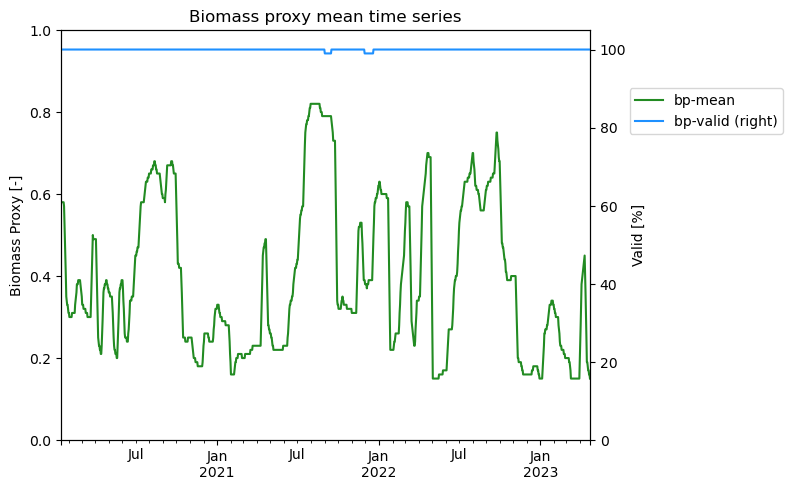

In [20]:
ax1 = df[["bp-mean"]].plot(color="forestgreen", secondary_y='bp-valid', legend=False)
fig = ax1.figure
ax2 = df[['bp-valid']].plot(color="dodgerblue", ax=ax1, secondary_y=True, legend=False)
fig.legend(bbox_to_anchor=(0.95, 0.8), loc="center left")
fig.tight_layout()

ax1.set_title("Biomass proxy mean time series")
ax1.set_ylabel("Biomass Proxy [-]")
ax2.set_ylabel("Valid [%]")
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 105)